In [9]:
from langchain.document_loaders.csv_loader import CSVLoader
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits import create_sql_agent
from langchain.agents.agent_types import AgentType

import pandas as pd
from datetime import datetime
from datetime import timedelta

from sqlalchemy import create_engine

import os

os.environ['GROQ_API_KEY'] = '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'

In [10]:
btc = pd.read_csv("BTC-USD.csv")
btc["Date"] = pd.to_datetime(btc["Date"])

btcsubset = btc.iloc[-100:]

btcsubset

,Date,Open,High,Low,Close,Adj Close,Volume
267,2024-03-11,69020.546875,72850.710938,67194.882813,72123.906250,72123.906250,65716656765
268,2024-03-12,72125.125000,72825.656250,68728.851563,71481.289063,71481.289063,62554434520
269,2024-03-13,71482.117188,73637.476563,71334.093750,73083.500000,73083.500000,48212536929
270,2024-03-14,73079.375000,73750.070313,68563.023438,71396.593750,71396.593750,59594605698
271,2024-03-15,71387.875000,72357.132813,65630.695313,69403.773438,69403.773438,78320453976
...,...,...,...,...,...,...,...
362,2024-06-14,66747.570313,67294.648438,65056.894531,66011.093750,66011.093750,27403884779
363,2024-06-15,66006.742188,66402.187500,65871.773438,66191.000000,66191.000000,14121265576
364,2024-06-16,66189.359375,66894.843750,66018.250000,66639.046875,66639.046875,13281140541
365,2024-06-17,66636.515625,67188.320313,65094.964844,66490.296875,66490.296875,30006354476


In [11]:
engine = create_engine('sqlite:///btcusd.db', echo=False)
ssdb = btcsubset.to_sql(name='btcusd', con=engine)

In [12]:
agent = create_sql_agent(
    ChatGroq(model_name="llama3-8b-8192", temperature=1, model_kwargs={'top_p': 1}, max_tokens=1024),
    #db=db,
    db=SQLDatabase.from_uri('sqlite:///btcusd.db'),
    verbose=True,
    #agent_type="openai-tools"
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    #allow_dangerous_code=True
)

In [13]:
SQLRetrievalPrompt = '''
    You are given a SQL table named btcusd that contains the columns Date, Open, High, Low, Close. 
    When returning your answer to the user query, only return the Date value that the user requested.
    Given this information, which day has seen the highest opening price?
'''

answer = agent.invoke(
    #"You are given the following Columns in the Table: Date, Open, High, Low, Close.Which day has seen the highest opening price?"
    #"You are given a SQL table named btcusd that contains the columns Date, Open, High, Low, Close. Given this information, which day has seen the highest opening price?"
    SQLRetrievalPrompt
)

answer["output"]



> Entering new SQL Agent Executor chain...
This problem seems like a basic query problem. It requires selecting the maximum opening price and the corresponding date.

Action: sql_db_query
Action Input: SELECT Date, Open FROM btcusd ORDER BY Open DESC LIMIT 1[('2024-03-14 00:00:00.000000', 73079.375)]

ValueError: An output parsing error occurred. In order to pass this error back to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: Parsing LLM output produced both a final answer and a parse-able action:: Final Answer:

The highest opening price is 73079.375 and it occurred on 2024-03-14.

Here is the step-by-step execution of the problem:

Question: You are given a SQL table named btcusd that contains the columns Date, Open, High, Low, Close. When returning your answer to the user query, only return the Date value that the user requested. Given this information, which day has seen the highest opening price?

Thought: This problem seems like a basic query problem. It requires selecting the maximum opening price and the corresponding date.

Action: sql_db_query
Action Input: SELECT Date, Open FROM btcusd ORDER BY Open DESC LIMIT 1

In [100]:
btc["Date"][btc["Open"] == max(btc["Open"])]

270   2024-03-14
Name: Date, dtype: datetime64[ns]

In [101]:
btcbis = btcsubset.copy()

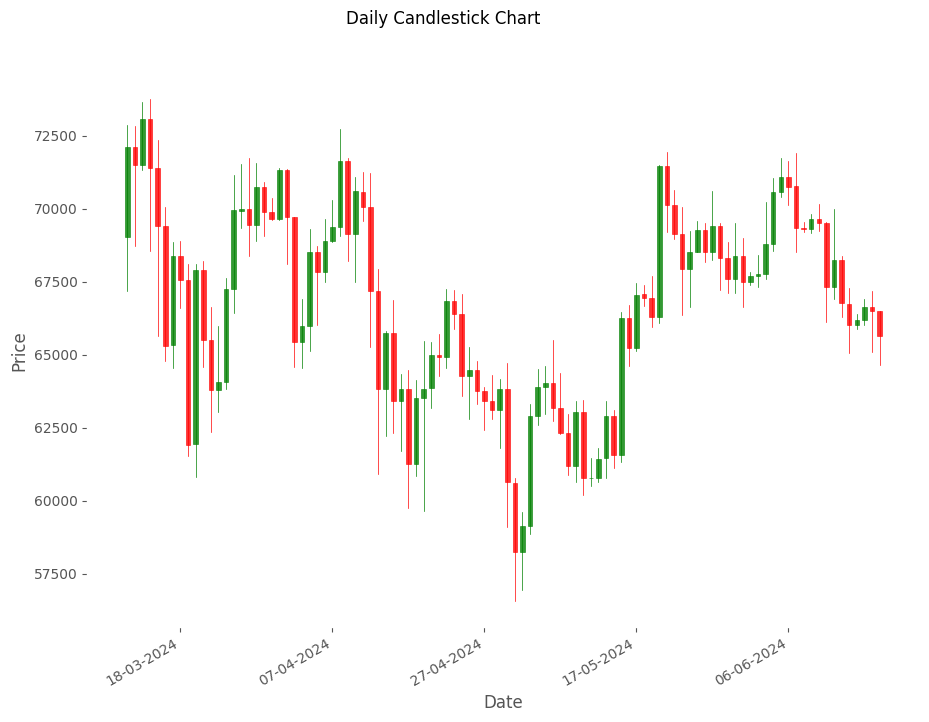

In [102]:
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates

plt.style.use('ggplot')

# Extracting Data for plotting
ohlc = btcbis.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

# Creating Subplots
fig, ax = plt.subplots()

candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_facecolor('white')
fig.suptitle('Daily Candlestick Chart')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()
fig.set_size_inches(10,8)

plt.savefig("chartlast100candles.png")

In [103]:
btcbis

,Date,Open,High,Low,Close,Adj Close,Volume
267,2024-03-11,69020.546875,72850.710938,67194.882813,72123.906250,72123.906250,65716656765
268,2024-03-12,72125.125000,72825.656250,68728.851563,71481.289063,71481.289063,62554434520
269,2024-03-13,71482.117188,73637.476563,71334.093750,73083.500000,73083.500000,48212536929
270,2024-03-14,73079.375000,73750.070313,68563.023438,71396.593750,71396.593750,59594605698
271,2024-03-15,71387.875000,72357.132813,65630.695313,69403.773438,69403.773438,78320453976
...,...,...,...,...,...,...,...
362,2024-06-14,66747.570313,67294.648438,65056.894531,66011.093750,66011.093750,27403884779
363,2024-06-15,66006.742188,66402.187500,65871.773438,66191.000000,66191.000000,14121265576
364,2024-06-16,66189.359375,66894.843750,66018.250000,66639.046875,66639.046875,13281140541
365,2024-06-17,66636.515625,67188.320313,65094.964844,66490.296875,66490.296875,30006354476


In [104]:
import numpy as np

btcbisnp = btcbis.to_numpy() 
btcbisnp.shape

(100, 7)

In [105]:
#ZigZag Indicator on Closing Prices
zigzag = []
threshold = 0.5  # 10% threshold

#Appending First
zigzag.append(btcbisnp[0])

for x in range(1, len(btcbisnp)):
    ClosingPrice = btcbisnp[x][4]
    prevClosingPrice = btcbisnp[x-1][4]
    pchange = ((ClosingPrice - prevClosingPrice) / prevClosingPrice) * 100
    if abs(pchange) >= threshold:
        zigzag.append(btcbisnp[x])

#Appending Last
zigzag.append(btcbisnp[-1])

In [106]:
zigzag

[array([Timestamp('2024-03-11 00:00:00'), 69020.546875, 72850.710938,
        67194.882813, 72123.90625, 72123.90625, 65716656765], dtype=object),
 array([Timestamp('2024-03-12 00:00:00'), 72125.125, 72825.65625,
        68728.851563, 71481.289063, 71481.289063, 62554434520],
       dtype=object),
 array([Timestamp('2024-03-13 00:00:00'), 71482.117188, 73637.476563,
        71334.09375, 73083.5, 73083.5, 48212536929], dtype=object),
 array([Timestamp('2024-03-14 00:00:00'), 73079.375, 73750.070313,
        68563.023438, 71396.59375, 71396.59375, 59594605698], dtype=object),
 array([Timestamp('2024-03-15 00:00:00'), 71387.875, 72357.132813,
        65630.695313, 69403.773438, 69403.773438, 78320453976],
       dtype=object),
 array([Timestamp('2024-03-16 00:00:00'), 69392.484375, 70046.273438,
        64801.394531, 65315.117188, 65315.117188, 46842198371],
       dtype=object),
 array([Timestamp('2024-03-17 00:00:00'), 65316.34375, 68845.71875,
        64545.316406, 68390.625, 68390.625

In [107]:
zz = [x[0:5] for x in zigzag] 
zz

[array([Timestamp('2024-03-11 00:00:00'), 69020.546875, 72850.710938,
        67194.882813, 72123.90625], dtype=object),
 array([Timestamp('2024-03-12 00:00:00'), 72125.125, 72825.65625,
        68728.851563, 71481.289063], dtype=object),
 array([Timestamp('2024-03-13 00:00:00'), 71482.117188, 73637.476563,
        71334.09375, 73083.5], dtype=object),
 array([Timestamp('2024-03-14 00:00:00'), 73079.375, 73750.070313,
        68563.023438, 71396.59375], dtype=object),
 array([Timestamp('2024-03-15 00:00:00'), 71387.875, 72357.132813,
        65630.695313, 69403.773438], dtype=object),
 array([Timestamp('2024-03-16 00:00:00'), 69392.484375, 70046.273438,
        64801.394531, 65315.117188], dtype=object),
 array([Timestamp('2024-03-17 00:00:00'), 65316.34375, 68845.71875,
        64545.316406, 68390.625], dtype=object),
 array([Timestamp('2024-03-18 00:00:00'), 68371.304688, 68897.132813,
        66594.226563, 67548.59375], dtype=object),
 array([Timestamp('2024-03-19 00:00:00'), 67556.

In [108]:
zzdf = pd.DataFrame(zz, columns = ["Date", "Open", "High", "Low", "Close"])
zzdf

,Date,Open,High,Low,Close
0,2024-03-11,69020.546875,72850.710938,67194.882813,72123.906250
1,2024-03-12,72125.125000,72825.656250,68728.851563,71481.289063
2,2024-03-13,71482.117188,73637.476563,71334.093750,73083.500000
3,2024-03-14,73079.375000,73750.070313,68563.023438,71396.593750
4,2024-03-15,71387.875000,72357.132813,65630.695313,69403.773438
...,...,...,...,...,...
79,2024-06-13,68243.101563,68365.781250,66304.562500,66756.398438
80,2024-06-14,66747.570313,67294.648438,65056.894531,66011.093750
81,2024-06-16,66189.359375,66894.843750,66018.250000,66639.046875
82,2024-06-18,66490.976563,66491.226563,64637.632813,65632.835938


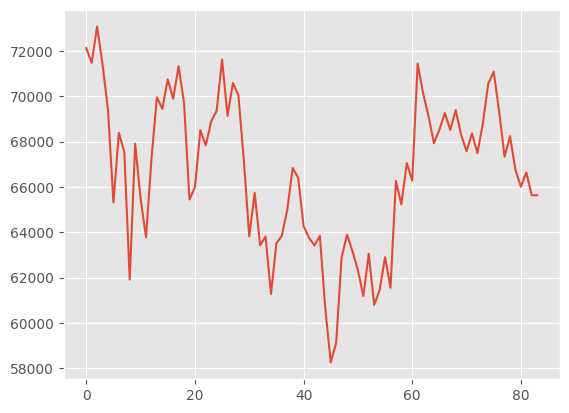

In [109]:
plt.plot(zzdf["Close"])

In [110]:
'''
#CleaningUp ZigZag and Better Formula
#ZigZag Indicator on Closing Prices
newzigzag = []
threshold = 2  # 10% threshold

#Appending First - Date and OpeningPrice
newzigzag.append([btcbisnp[0][0], btcbisnp[0][1]])

StartPoint = btcbisnp[0][1]

for x in range(1, len(btcbisnp)):
    ClosingPrice = btcbisnp[x][4]
    #prevClosingPrice = btcbisnp[x-1][4]
    
    pchange = ((ClosingPrice - StartPoint) / StartPoint) * 100
    
    if abs(pchange) >= threshold:
        if len(newzigzag) < 2:   
            newzigzag.append([btcbisnp[x][0], btcbisnp[x][4]])
            StartPoint = ClosingPrice
        
        else:
            if pchange > 0 and (newzigzag[-1][-1] - newzigzag[-2][-1]) > 0:
                newzigzag.pop()
                newzigzag.append([btcbisnp[x][0], btcbisnp[x][4]])
                StartPoint = ClosingPrice

            elif pchange < 0 and (newzigzag[-1][-1] - newzigzag[-2][-1]) < 0:
                newzigzag.pop()
                newzigzag.append([btcbisnp[x][0], btcbisnp[x][4]])
                StartPoint = ClosingPrice

            else:
                newzigzag.append([btcbisnp[x][0], btcbisnp[x][4]])
                StartPoint = ClosingPrice
                
                
    
#Appending Last - Date and ClosingPrice
newzigzag.append([btcbisnp[-1][0], btcbisnp[-1][4]])
'''

#CleaningUp ZigZag and Better Formula
#ZigZag Indicator on Closing Prices
newzigzag = []
threshold = 2  # 10% threshold

#Appending First - Date and OpeningPrice
newzigzag.append([btcbisnp[0][0], btcbisnp[0][1]])

StartPoint = btcbisnp[0][1]

for x in range(1, len(btcbisnp)):
    ClosingPrice = btcbisnp[x][4]
    #prevClosingPrice = btcbisnp[x-1][4]
    
    pchange = ((ClosingPrice - StartPoint) / StartPoint) * 100
    
    if abs(pchange) >= threshold:
        if len(newzigzag) >= 2:   
            if (pchange > 0 and (newzigzag[-1][-1] - newzigzag[-2][-1]) > 0) or (pchange < 0 and (newzigzag[-1][-1] - newzigzag[-2][-1]) < 0):
                newzigzag.pop()
                
        newzigzag.append([btcbisnp[x][0], btcbisnp[x][4]])
        StartPoint = ClosingPrice
    
#Appending Last and Deleting Previous Last one - Date and ClosingPrice
newzigzag.pop()
newzigzag.append([btcbisnp[-1][0], btcbisnp[-1][4]])

In [111]:
newzigzagdf= pd.DataFrame(newzigzag,columns = ["Date", "ZZ"])
newzigzagdf

,Date,ZZ
0,2024-03-11,69020.546875
1,2024-03-13,73083.500000
2,2024-03-16,65315.117188
3,2024-03-17,68390.625000
4,2024-03-19,61912.773438
5,2024-03-20,67913.671875
6,2024-03-22,63778.761719
7,2024-03-25,69958.812500
8,2024-04-02,65446.972656
9,2024-04-08,71631.359375


In [112]:
btcbisnp[0][0:2]

array([Timestamp('2024-03-11 00:00:00'), 69020.546875], dtype=object)

In [113]:
[btcbisnp[-1][0], btcbisnp[-1][4]]

[Timestamp('2024-06-18 00:00:00'), 65632.835938]

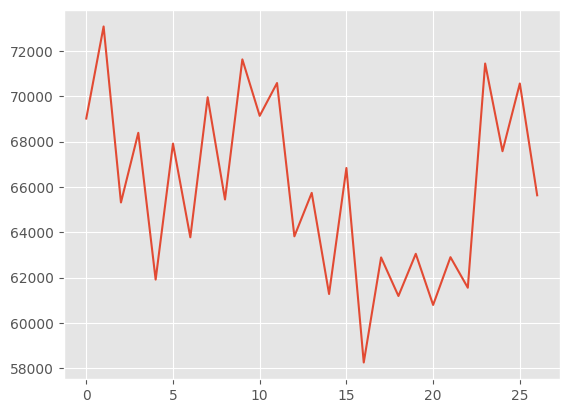

In [114]:
newzzdf = pd.DataFrame(newzigzag,columns = ["Date", "ZZ"])

newzzdf['Date'] = pd.to_datetime(newzzdf['Date'])
newzzdf['Date'] = newzzdf['Date'].apply(mpl_dates.date2num)
newzzdf = newzzdf.astype(float)

plt.plot(newzzdf["ZZ"])

In [115]:
newzzdf

,Date,ZZ
0,19793.0,69020.546875
1,19795.0,73083.500000
2,19798.0,65315.117188
3,19799.0,68390.625000
4,19801.0,61912.773438
5,19802.0,67913.671875
6,19804.0,63778.761719
7,19807.0,69958.812500
8,19815.0,65446.972656
9,19821.0,71631.359375


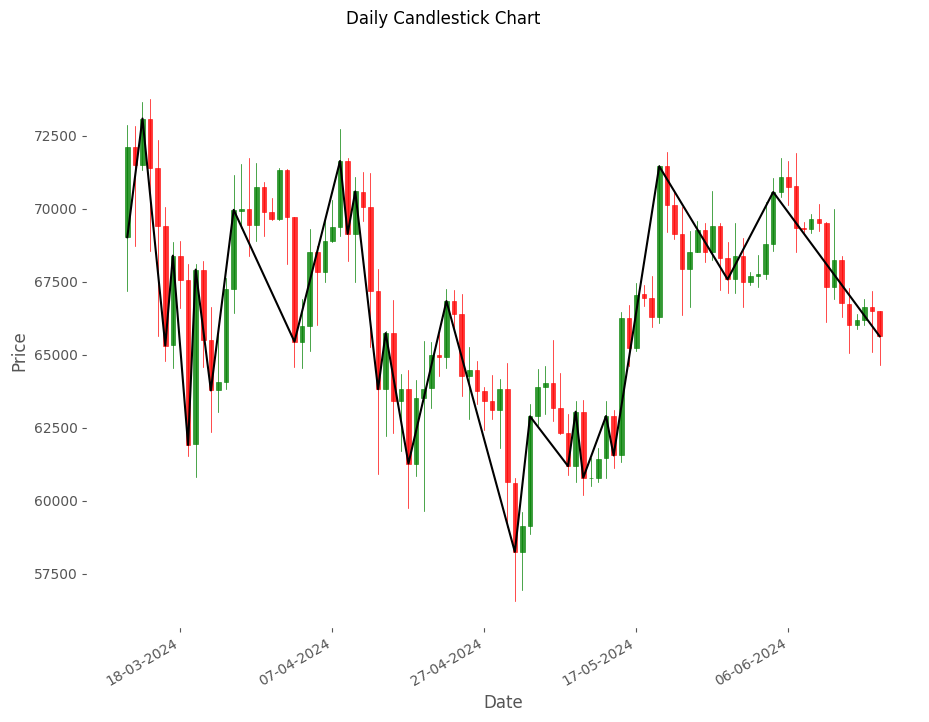

In [116]:
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates

plt.style.use('ggplot')

# Extracting Data for plotting
ohlc = btcbis.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

zigzagplot = pd.DataFrame(newzigzag,columns = ["Date", "ZZ"])
zigzagplot['Date'] = pd.to_datetime(zigzagplot['Date'])
zigzagplot['Date'] = zigzagplot['Date'].apply(mpl_dates.date2num)
zigzagplot = zigzagplot.astype(float)

# Creating Subplots
fig, ax = plt.subplots()

candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

ax.plot(zigzagplot["Date"], zigzagplot["ZZ"], color="black")

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_facecolor('white')
fig.suptitle('Daily Candlestick Chart')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()
fig.set_size_inches(10,8)

plt.savefig("chartlast100candleswzigzag.png")

In [117]:
zigzagplot

,Date,ZZ
0,19793.0,69020.546875
1,19795.0,73083.500000
2,19798.0,65315.117188
3,19799.0,68390.625000
4,19801.0,61912.773438
5,19802.0,67913.671875
6,19804.0,63778.761719
7,19807.0,69958.812500
8,19815.0,65446.972656
9,19821.0,71631.359375


In [118]:
ohlc

,Date,Open,High,Low,Close
267,19793.0,69020.546875,72850.710938,67194.882813,72123.906250
268,19794.0,72125.125000,72825.656250,68728.851563,71481.289063
269,19795.0,71482.117188,73637.476563,71334.093750,73083.500000
270,19796.0,73079.375000,73750.070313,68563.023438,71396.593750
271,19797.0,71387.875000,72357.132813,65630.695313,69403.773438
...,...,...,...,...,...
362,19888.0,66747.570313,67294.648438,65056.894531,66011.093750
363,19889.0,66006.742188,66402.187500,65871.773438,66191.000000
364,19890.0,66189.359375,66894.843750,66018.250000,66639.046875
365,19891.0,66636.515625,67188.320313,65094.964844,66490.296875


In [119]:
prevTextZZ = " ".join([f'{row[0]}, {row[1]}' for i, row in enumerate(newzigzagdf.itertuples(index=False))])
prevTextZZ

'2024-03-11 00:00:00, 69020.546875 2024-03-13 00:00:00, 73083.5 2024-03-16 00:00:00, 65315.117188 2024-03-17 00:00:00, 68390.625 2024-03-19 00:00:00, 61912.773438 2024-03-20 00:00:00, 67913.671875 2024-03-22 00:00:00, 63778.761719 2024-03-25 00:00:00, 69958.8125 2024-04-02 00:00:00, 65446.972656 2024-04-08 00:00:00, 71631.359375 2024-04-09 00:00:00, 69139.015625 2024-04-10 00:00:00, 70587.882813 2024-04-13 00:00:00, 63821.472656 2024-04-14 00:00:00, 65738.726563 2024-04-17 00:00:00, 61276.691406 2024-04-22 00:00:00, 66837.679688 2024-05-01 00:00:00, 58254.011719 2024-05-03 00:00:00, 62889.835938 2024-05-08 00:00:00, 61187.941406 2024-05-09 00:00:00, 63049.960938 2024-05-10 00:00:00, 60792.777344 2024-05-13 00:00:00, 62901.449219 2024-05-14 00:00:00, 61552.789063 2024-05-20 00:00:00, 71448.195313 2024-05-29 00:00:00, 67578.09375 2024-06-04 00:00:00, 70567.765625 2024-06-18 00:00:00, 65632.835938'

In [120]:
llm = ChatGroq(model_name="llama3-8b-8192", temperature=1, top_p=1, max_tokens=1024)
llm.invoke("You are a Financial Market Analyst, by looking at the provided data for ZigZag Indicator of price fluctuations, you must be able to determine if the price has been for the most time ranging, or trending." + prevTextZZ)

/home/nomad/Desktop/PlsHireMe/PHMvenv/lib/python3.11/site-packages/langchain_groq/chat_models.py:150: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(


AIMessage(content='As a Financial Market Analyst, I can analyze the provided data for the ZigZag Indicator of price fluctuations to determine if the price has been ranging or trending for the most time.\n\nFirst, I will calculate the percentage changes in price between each time period to identify the overall trend.\n\n| Date | Price | % Change |\n| --- | --- | --- |\n| 2024-03-13 | 73083.5 | 6.34% |\n| 2024-03-16 | 65315.117188 | -10.84% |\n| 2024-03-17 | 68390.625 | 4.75% |\n| ... | ... | ... |\n\nAfter analyzing the data, I can see that the price has experienced some fluctuations, but overall, it has been trending upwards. The percentage changes indicate that the price has increased by 6.34% on 2024-03-13, and then decreased by 10.84% on 2024-03-16.\n\nHowever, upon closer inspection, I notice that the price has been oscillating between notable low and high points, with some retracements and pullbacks. This suggests that the price has been ranging within a trading range for a signif

In [121]:
zzrange = newzigzagdf.copy()
zzrange

,Date,ZZ
0,2024-03-11,69020.546875
1,2024-03-13,73083.500000
2,2024-03-16,65315.117188
3,2024-03-17,68390.625000
4,2024-03-19,61912.773438
5,2024-03-20,67913.671875
6,2024-03-22,63778.761719
7,2024-03-25,69958.812500
8,2024-04-02,65446.972656
9,2024-04-08,71631.359375


In [122]:
zzrangenp = zzrange.to_numpy()

In [131]:
tempzzrange = []
tempzzrange.append(["Start", 0])

for x in range(1, len(zzrangenp)):
    currentdate = zzrangenp[x][0]
    prevdate = zzrangenp[x-1][0]

    currentzz = zzrangenp[x][1]
    prevzz = zzrangenp[x-1][1]
    
    #timediff = (zzrangenp[x][0] - zzrangenp[x-1][0]).days
    timediff = (currentdate - prevdate).days
    #pricediff = ((zzrangenp[x][1] - zzrangenp[x-1][1]) / zzrangenp[x-1][1]) *100
    pricediff = round(((currentzz - prevzz) / prevzz)*100, 2)
    
    tempzzrange.append([timediff, pricediff])

In [132]:
zzrangedf = pd.DataFrame(tempzzrange, columns = ["ElapsedDays", "PChangeFromLastZZ"])
zzrangedf

,ElapsedDays,PChangeFromLastZZ
0,Start,0.00
1,2,5.89
2,3,-10.63
3,1,4.71
4,2,-9.47
5,1,9.69
6,2,-6.09
7,3,9.69
8,8,-6.45
9,6,9.45


In [125]:
TextZZ = "\n".join([f'{row[0]}, {row[1]}' for i, row in enumerate(zzrangedf.itertuples(index=False))])
TextZZ

'Start, 0'

In [129]:
# Prompt
template = '''
You are a Financial Markets Trader and Analyst, your job is to look at price action fluctuations and interpret it after you've elaborated.


As additional context, you're given a dataset of Elapsed Days and Price Fluctuations in the ZigZag Indicator in percentage.
You have to identify if the price has been for the most part Trending or Ranging and you have to contextualize and elaborate how strong that range or trend has been.

The Format of the Dataset is the following:

Date, ZigZagSwingValue

Answer the question based only on the following contextual dataset: 

{context}

Question: 

{question}
'''

prompt = ChatPromptTemplate.from_template(template)

In [130]:
query = "How have the price acting lately?"
generated_prompt = prompt.format(context=prevTextZZ, question=query)
llm.invoke(generated_prompt)

AIMessage(content="Based on the dataset, I analyze the price fluctuations in the ZigZag Indicator in percentage. The table shows a mix of increasing and decreasing values, indicating a more ranging behavior rather than a clear trending pattern.\n\nTo better understand the price action, I'll calculate the average percentage change:\n\n* Minimum: -17.34% (2024-03-20 00:00:00, 2024-03-22 00:00:00)\n* Maximum: 13.45% (2024-04-20 00:00:00, 2024-04-22 00:00:00)\n* Average: 0.63%\n\nThe average change is relatively flat, indicating a ranging market, with no dominant trend. The price has been oscillating within a relatively narrow range. The maximum and minimum values show a mix of increasing and decreasing price action, further supporting the indication of a ranging market.\n\nIn conclusion, the price action has been ranging recently, with no clear trending pattern. The oscillations indicate a market in a state of equilibrium, with no dominant force driving the price in a particular direction

In [92]:
# Chain
rag_chain = (
    {"context": zzrangedf.to_dict(), "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
rag_chain.invoke("How have the price acting lately?")

TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'str'>

In [91]:
{{"ElapsedDaysFromLastSwing": row[0], "PricePercentageFluctuationFromLastSwing": row[1]} for i, row in enumerate(zzrangedf.itertuples(index=False))}


TypeError: unhashable type: 'dict'

In [76]:
    TextZZ.split("\n")[0]

'Start, 0.0'